In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [238]:
from ase.io.extxyz import read_xyz
import numpy as np
from ase.atoms import Atoms
from ase.io.formats import index2range
from ase.io.cfg import read_cfg
from io import StringIO, UnsupportedOperation
from mtp import *
import os
from matplotlib import pyplot as plt
from quippy.potential import Potential
import pickle
from Ge_analysis import *
from Ge_calculation import *
import matplotlib.pyplot as plt
from matscipy.rings import ring_statistics
from datetime import datetime
import pymatgen.ext.matproj as mp
import pymatgen.io.ase as pase
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from numpy.random import normal
from ase.io.extxyz import write_xyz
from ase.io.lammpsdata import write_lammps_data
from ase.io.castep import read_cell, write_cell
from ase.visualize import view
from ase.io.trajectory import Trajectory
from ase.io.castep import read_seed
from os.path import join
from ase.optimize import BFGSLineSearch
from re import findall

In [3]:
mpl.style.use('VLD')

## Getting AIRSS up and running for building cells

In [4]:
os.chdir('/u/vld/hert5155/jup_remote/Ge_od/rss/Si_solid8')

In [23]:
pot = MTP('/home/tridymite/vld/hert5155/jup_remote/Ge_od/GAP_to_MTP/MTPs/MTPs/u24_m1.5_fw0.1_PQ_rand_retrain_fromGAP18db.mtp',
         potential_name='u24_fw0.1_rand', mtp_command='/home/tridymite/vld/hert5155/mlip-2/bin/mlp', parallel=False)

In [151]:
u16_rand = MTP('/home/tridymite/vld/hert5155/jup_remote/Ge_od/GAP_to_MTP/MTPs/MTPs/u16_m1.5_fw0.1_PQ1k_G18_scratch.mtp',
              potential_name='u16_fw0.1_rand', mtp_command='/home/tridymite/vld/hert5155/mlip-2/bin/mlp', parallel=False)

In [ ]:
GAP_18_dir = '/u/vld/hert5155/jup_remote/Ge_od/Si_GAP_training/libAtoms-silicon-testing-framework-fc252cb/models/GAP'
g18 = Potential(param_filename=GAP_18_dir+'/gp_iter6_sparse9k.xml')

In [241]:
g18_lv = Potential(param_filename=GAP_18_dir+'/gp_iter6_sparse9k.xml',
                  calc_args='local_gap_variance')

RuntimeError: Traceback (most recent call last)
  File "/u/vld/hert5155/QUIP/src/libAtoms/System.f95", line 520 kind unspecified
    IO error opening "gp_iter6_sparse9k.xml" on unit 8, error number: 5004                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [244]:
g18_lv.calculate(dia_ref, args_str='local_gap_variance')

In [246]:
g18_lv.extra_results

{'config': {},
 'atoms': {'local_gap_variance': array([1.04081829e-06, 1.04081825e-06, 1.04081825e-06, 1.04081830e-06,
         1.04081829e-06, 1.04081827e-06, 1.04081832e-06, 1.04081828e-06]),
  'gap_variance_gradient': array([[-5.16519964e-13, -5.12242568e-13,  2.51596728e-13],
         [ 5.37462482e-13,  5.02743956e-13, -2.64674252e-13],
         [-5.18705772e-13, -5.16414940e-13,  2.83877486e-13],
         [ 5.33777645e-13,  5.19409003e-13, -2.67716572e-13],
         [-5.07532885e-13, -5.09974497e-13,  2.89811314e-13],
         [ 4.91786624e-13,  5.08617786e-13, -2.71950940e-13],
         [-5.11660883e-13, -5.15608734e-13,  2.50431905e-13],
         [ 4.92352668e-13,  5.24155823e-13, -2.70460160e-13]])}}

In [24]:
c = read_cell('Si_1.cell')
pot.calculate(c)

In [135]:
def opt(at, pot, P, fmax=5e-2, traj='tmp.traj', silent=False, name='NA', steps=100):
    '''Arguments
    init_structs: list of initial geometries for optimisation (must be close enough)
    pot: calculator object with which to perform opt
    P: pressure / eVA^-3'''

    at = at.copy()
    
    at.set_calculator(pot)
    #at.set_constraint(FixAtoms(mask=[True for atom in at]))
    uf = ExpCellFilter(at, scalar_pressure=P, hydrostatic_strain=True) # should ensure only the lattice can move, not atomic positions
    if silent:
        opt = BFGSLineSearch(atoms=uf, trajectory=traj, logfile='/dev/null')
    else:
        opt = BFGSLineSearch(atoms=uf, trajectory=traj)
                       
    opt.run(fmax, steps=steps) # converge to 0.1 GPa

    if not opt.converged():
        warnings.warn(('Warning: failed to converge on structure{}\n' +\
                      'in {} steps').format(Na, steps))
        #at.set_cell(np.NaN*np.ones(3)) # flag unconverged geometry

    at.set_calculator(None)

    return at, opt

In [39]:
cn = opt(c, g18, 0, silent=True)

In [40]:
traj = Trajectory('tmp.traj')

In [41]:
view(traj, viewer='ngl')

In [43]:
cells = [read_cell(i) for i in os.listdir() if 'Si_' in i]

In [49]:
opts = []; g18_e = []; mtp_e = []; mtp_f = []; g18_f = []
for ct, i in enumerate(cells):
    opts.append(opt(i, g18, 0, traj='{}.traj'.format(ct), silent=True))
    
    opts[-1].calc = g18
    g18_e.append(opts[-1].get_potential_energy())
    g18_f.append(opts[-1].get_forces())
    
    opts[-1].calc = pot
    mtp_e.append(opts[-1].get_potential_energy())
    mtp_f.append(opts[-1].get_forces())
    

<ipython-input-38-9bc962ca00a5>:20: UserWarning: Warning: failed to converge on structure
in 100 steps
  warnings.warn(('Warning: failed to converge on structure\n' +\


In [87]:
g18_e = np.array(g18_e); mtp_e = np.array(mtp_e)

In [72]:
with open('Si_g18opt_castep.pickle', 'rb') as f:
    cas = pickle.load(f)

In [85]:
cas_e = np.array([i.info['dft_energy'] for i in cas])
cas_f = np.array([i.arrays['dft_force'] for i in cas])

In [82]:
dia_ref = read_seed('dia_ref/dia_geom_1')
cas_e_ref = dia_ref.get_potential_energy()
dia_ref.calc = g18
g18_e_ref = dia_ref.get_potential_energy()
dia_ref.calc = pot
mtp_e_ref = dia_ref.get_potential_energy()

In [57]:
for i, val in enumerate(opts):
    with open('Si_g18opt_{}.cell'.format(i+1), 'w') as f:
        write_cell(f, val)

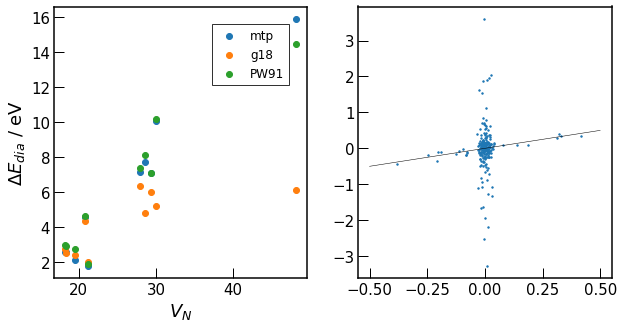

In [92]:
fig, (axs, axs2) = plt.subplots(1,2, figsize=(10,5))
v = [i.get_volume()/len(i) for i in opts]
axs.scatter(v, mtp_e - mtp_e_ref, label='mtp')
axs.scatter(v, g18_e - g18_e_ref, label='g18')
axs.scatter(v, cas_e - cas_e_ref, label='PW91')
axs.set(ylabel=r'$\Delta E_{dia}$ / eV', xlabel='$V_{N}$')
axs.legend()
# axs2.scatter(v, np.array(mtp_f).ravel(), label='mtp')
# axs2.scatter(v, np.array(g18_f).ravel(), label='g18')
axs2.scatter(np.array(g18_f).ravel(), np.array(mtp_f).ravel(), s=2)
axs2.plot(x:=np.linspace(-0.5,0.5), x, linewidth=0.5, color='k')

## More formalised

In [117]:
c_dir = 'build_test3'
cs = [read_cell(join(c_dir, i)) for i in os.listdir(c_dir) if 'Si_' in i]

In [118]:
uo_g18_e2 = []; uo_mtp_e2 = []; uo_g18_f2 = []; uo_mtp_f2 = []; 
for ct, i in enumerate(cs):
    
    i.calc = g18
    uo_g18_e2.append(i.get_potential_energy())
    uo_g18_f2.append(i.get_forces())
    
    i.calc = pot
    uo_mtp_e2.append(i.get_potential_energy())
    uo_mtp_f2.append(i.get_forces())

uo_g18_e2 = np.array(uo_g18_e2); uo_mtp_e2 = np.array(uo_mtp_e2)
uo_g18_f2 = np.array(uo_g18_f2); uo_mtp_f2 = np.array(uo_mtp_f2)

In [136]:
opts_2 = []; g18_e2 = []; mtp_e2 = []; mtp_f2 = []; g18_f2 = []; failed = []
for ct, i in enumerate(cs):
    
    at, n_opt = opt(i, g18, 0, traj='{}.traj'.format(ct), silent=True, name=ct)
    
    at.calc = g18
    if not n_opt.converged():
        failed.append(ct)
    at.calc = None
    
    opts_2.append(at)
    
    opts_2[-1].calc = g18
    g18_e2.append(opts_2[-1].get_potential_energy())
    g18_f2.append(opts_2[-1].get_forces())
    
    opts_2[-1].calc = pot
    mtp_e2.append(opts_2[-1].get_potential_energy())
    mtp_f2.append(opts_2[-1].get_forces())
g18_e2 = np.array(g18_e2); mtp_e2 = np.array(mtp_e2)

In [156]:
dia_ref.calc = u16_rand
u16_rand_e_ref = dia_ref.get_potential_energy()

In [155]:
u16_rand_e2 = []; u16_rand_f2 = []
for ct, i in enumerate(opts_2):
    at = i.copy()
    at.calc = u16_rand
    u16_rand_e2.append(at.get_potential_energy())
    u16_rand_f2.append(at.get_forces())
    at.calc = None

In [159]:
u16_rand_e2 = np.array(u16_rand_e2); u16_rand_f2 = np.array(u16_rand_f2)

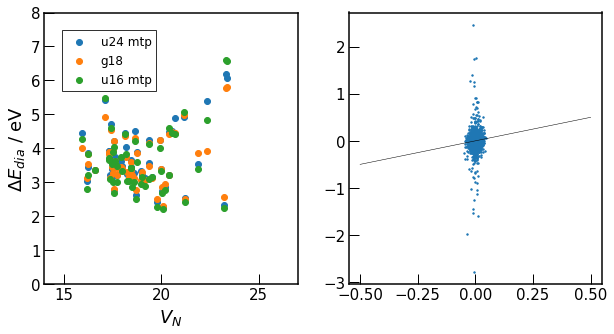

In [162]:
fig, (axs, axs2) = plt.subplots(1,2, figsize=(10,5))
v = np.array([i.get_volume()/len(i) for i in opts_2])
axs.scatter(v, mtp_e2 - mtp_e_ref, label='u24 mtp')
axs.scatter(v, g18_e2 - g18_e_ref, label='g18')
axs.scatter(v, u16_rand_e2 - u16_rand_e_ref, label='u16 mtp')
axs.set(xlim=(14,27), ylim=(0,8))
# axs.scatter(v, cas_e2 - cas_e_ref, label='PW91')
axs.set(ylabel=r'$\Delta E_{dia}$ / eV', xlabel='$V_{N}$')
axs.legend()
# axs2.scatter(v, np.array(mtp_f).ravel(), label='mtp')
# axs2.scatter(v, np.array(g18_f).ravel(), label='g18')
axs2.scatter(np.array(g18_f2).ravel(), np.array(mtp_f2).ravel(), s=2)
axs2.plot(x:=np.linspace(-0.5,0.5), x, linewidth=0.5, color='k')

In [167]:
rms_dict(g18_e2[np.where(v<27)], mtp_e2[np.where(v<27)]), rms_dict(g18_e2, mtp_e2)

({'rmse': 0.2865275677257074, 'std': 0.31550703698018123},
 {'rmse': 1.344728110994009, 'std': 11.063602049462817})

In [169]:
rms_dict(g18_e2[np.where(v<27)], u16_rand_e2[np.where(v<27)]), rms_dict(g18_e2, u16_rand_e2) 

({'rmse': 0.2924451208651083, 'std': 0.21864157103785237},
 {'rmse': 1.3729448855845934, 'std': 11.35978975958231})

In [119]:
rms_dict(uo_g18_e2, uo_mtp_e2)

{'rmse': 3.1364042022969696, 'std': 19.113838378560715}

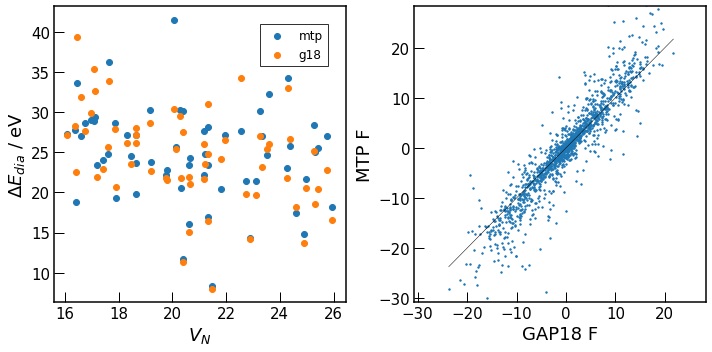

In [127]:
fig, (axs, axs2) = plt.subplots(1,2, figsize=(10,5))
v = [i.get_volume()/len(i) for i in cs]
axs.scatter(v, uo_mtp_e2 - mtp_e_ref, label='mtp')
axs.scatter(v, uo_g18_e2 - g18_e_ref, label='g18')
# axs.scatter(v, uo_cas_e2 - cas_e_ref, label='PW91')
axs.set(ylabel=r'$\Delta E_{dia}$ / eV', xlabel='$V_{N}$')
axs.legend()
# axs2.scatter(v, np.array(mtp_f).ravel(), label='mtp')
# axs2.scatter(v, np.array(g18_f).ravel(), label='g18')
axs2.scatter(np.array(uo_g18_f2).ravel(), np.array(uo_mtp_f2).ravel(), s=2)
axs2.plot(x:=np.linspace(mi:=uo_g18_f2.min(),ma:=uo_g18_f2.max()), x, linewidth=0.5, color='k')
axs2.set(xlabel=('GAP18 F'), ylabel='MTP F', xlim=(mi*1.3,ma*1.3), ylim=(mi*1.3,ma*1.3))
fig.tight_layout()

In [192]:
def gap_rss(cell_dir, opt_pot, eval_pot, ref_at):
    '''
    Retuns: uo_opt, uo_eval, o_opt, o_eval, refs, opts
    '''
    
    
    cs = sorted([join(c_dir, i) for i in os.listdir(c_dir) if 'Si_' in i],
                key=lambda f: int(findall('\d+', f)[-1]))
    
    cs = [read_cell(i) for i in cs]
    
    ######### Reference calculation ###################
    ref_at.calc = opt_pot
    refs = [ref_at.get_potential_energy()]
    
    ref_at.calc = eval_pot
    refs.append(ref_at.get_potential_energy())

                
    ######### Evaluate unoptimised geometries ##########
                
    uo_opt = [[], [], [], []]; uo_eval = [[], [], []]; 

    for ct, i in enumerate(cs):

        i.calc = opt_pot
        uo_opt[0].append(i.get_potential_energy())
        uo_opt[1].append(i.get_forces())
        uo_opt[2].append(i.get_stress())
        uo_opt[3].append(i.get_potential_energies())
                

        i.calc = eval_pot
        uo_eval[0].append(i.get_potential_energy())
        uo_eval[1].append(i.get_forces())
        uo_eval[2].append(i.get_stress())

    uo_opt = [np.array(i) for i in uo_opt]
    uo_eval = [np.array(i) for i in uo_eval]
                
    #### Optimised geometries #########################
                
    pts = []; failed = []; opts = []
    o_opt = [[], [], [], []]; o_eval = [[], [], []];
    
    for ct, i in enumerate(cs):

        at, n_opt = opt(i, opt_pot, 0,
                        traj=join(cell_dir, '{}.traj'.format(ct)),
                        silent=True, name=ct)

        at.calc = opt_pot
        if not n_opt.converged():
            failed.append(ct)
        at.calc = None

        opts.append(at)
        at.calc = opt_pot
        o_opt[0].append(at.get_potential_energy())
        o_opt[1].append(at.get_forces())
        o_opt[2].append(at.get_stress())
        o_opt[3].append(at.get_potential_energies())
                

        at.calc = eval_pot
        o_eval[0].append(at.get_potential_energy())
        o_eval[1].append(at.get_forces())
        o_eval[2].append(at.get_stress())
        
        at.calc = None
        
    o_opt = [np.array(i) for i in o_opt]
    o_eval = [np.array(i) for i in o_eval]
    
    return [uo_opt, uo_eval, o_opt, o_eval, refs, opts, cs]

In [193]:
g18,pot.name

(<quippy.potential.Potential at 0x7f092f14a9a0>, 'u24_fw0.1_rand')

In [194]:
sym_out = gap_rss('build_test_sym', g18, pot, dia_ref)

In [195]:
sym_out

[[array([-1280.02280454, -1294.09453355, -1284.37079483, -1278.30093858,
         -1284.8391845 , -1279.28567257, -1281.85653804, -1278.762838  ,
         -1280.0252464 , -1278.87502972, -1281.85886529, -1288.94817013,
         -1279.75853562, -1278.46120621, -1266.09620371, -1283.74666316,
         -1282.26297562, -1282.65819878, -1277.79119899, -1274.46666487,
         -1275.56762067, -1285.05297881, -1283.93599986, -1283.67820675,
         -1273.50399512, -1283.64411423, -1291.1907421 , -1290.38224842,
         -1279.2494982 , -1280.61039736, -1282.71419838, -1281.26452926,
         -1277.1547304 , -1275.95524228, -1280.23894353, -1286.81379685,
         -1285.65588515, -1284.79548454, -1272.40069791, -1283.49214069,
         -1277.53988097, -1270.09774969, -1288.79944417, -1297.42145988,
         -1275.05572599, -1276.79174075, -1279.40846294, -1283.6579592 ,
         -1285.77419293, -1282.56220391, -1271.52636848, -1279.45387432,
         -1272.85721921, -1291.73155661, -1282.8867

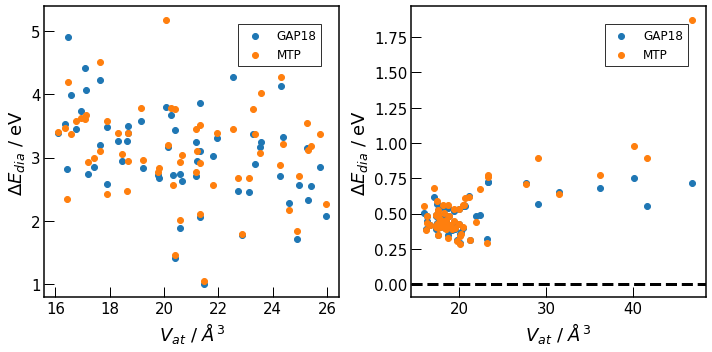

In [249]:
fig, (axs, axs2) = plt.subplots(1,2, figsize=(10,5))
s = sym_out
opts = s[5]
ref = s[4]
vs_opt = np.array([i.get_volume()/len(i) for i in opts])
vs_unopt = np.array([i.get_volume()/len(i) for i in cs])
non_exp = np.argwhere(vs_opt<26).T.squeeze()

axs.scatter(vs_unopt, s[0][0]/len(opts[0]) - ref[0]/len(dia_ref), label='GAP18')
axs.scatter(vs_unopt, s[1][0]/len(opts[0]) - ref[1]/len(dia_ref), label='MTP')
axs.legend()
axs.set(ylabel=r'$\Delta E_{dia}$ / eV', xlabel=r'$V_{at}$ / $\AA^3$')

axs2.scatter(vs_opt, s[2][0]/len(opts[0]) - ref[0]/len(dia_ref), label='GAP18')
axs2.scatter(vs_opt, s[3][0]/len(opts[0]) - ref[1]/len(dia_ref), label='MTP')
axs2.legend()
axs2.axhline(0, color='k', linestyle='--')
axs2.set(ylabel=r'$\Delta E_{dia}$ / eV', xlabel=r'$V_{at}$ / $\AA^3$')

fig.tight_layout()

In [224]:
rms_dict(s[0][0], s[1][0]), rms_dict(s[2][0], s[3][0])

({'rmse': 3.1364042022969696, 'std': 19.113838378560715},
 {'rmse': 1.344723887580778, 'std': 11.063600835718795})

In [ ]:
targets = np.argwhere(vs_opt<26).T.squeeze()

In [232]:
non_exp = np.argwhere(vs_opt<26).T.squeeze()

In [233]:
rms_dict(s[2][1][non_exp], s[3][1][non_exp])

{'rmse': 0.1340075770877777, 'std': 0.03530623630269002}

In [250]:
kernel_compare(opts, [dia_ref])

ValueError: operand has more dimensions than subscripts given in einstein sum, but no '...' ellipsis provided to broadcast the extra dimensions.

## need to check that ase-opt reflects quip-opt

In [ ]:
from ase.calculators import castep
from ase.io import castep as iocastep
import os
import numpy as np
from copy import deepcopy
import pickle
from glob import glob
from re import findall

tag = 'Si_g18opt'
files = sorted(glob(tag+'*'), key=lambda f: int(findall('\d+', f)[-1]))
print('sorted files:', files)

directory = './Si_g18opt'
ats = []
inits = []
for i in files:
    with open(i, 'r') as f:
        inits.append(iocastep.read_cell(f))
i = 0 

for ct, val in enumerate(inits):
    calc = castep.Castep(castep_command='mpirun -np $NMPI /usr/local/CASTEP-20/castep.mpi')
    calc._prepare_input_only=True
    val.calc = calc

    calc.set_kpts({'spacing' : 0.05})
    calc.merge_param('/u/vld/hert5155/scripts/castep/template.param')
    calc.param.elec_energy_tol = 1e-5
    calc.param.xc_functional = 'PW91'

    calc._directory = directory
    calc._rename_existing_dir = False
    calc._label = '{}_{}'.format(tag, ct+1) # start label indexing from 1, currently
    print('\n{}\n'.format(calc._label))

    out = None
    
    if os.path.isdir(directory): # check if calculation is a restart (i.e. already done')
        if calc._label + '.castep' in os.listdir(directory):
            try:
                out = iocastep.read_seed(os.path.join(directory, calc._label))
                print('Existing .castep found and read. Warnings associated: {}'.format(out.calc._warnings))
            except:
                print('.castep found, but can\'t be read correctly so reoptimising geometry')

    if out is None:
        if calc.dryrun_ok():
            print('%s : %s ' % (val.calc._label, val.get_potential_energy()))
            out = iocastep.read_seed(os.path.join(directory, calc._label))
        else:
            print("Found error in input")
            print(calc._error)
    


# Fragment identification work